# NLP COVID Vax Modeling

In [1]:
import pandas as pd
import numpy as np

import re
import string
import nltk
import contractions

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option("max_colwidth", 0)
pd.set_option('max_columns', 35)
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

## Import data 

In [2]:
# import cleaned DF from prior notebook

vax_df = pd.read_csv('vax_df.csv')
vax_df.head()

,created_at,hashtags,in_reply_to_screen_name,quote_id,retweet_id,retweet_screen_name,user_id,user_screen_name,user_description,user_location,text
0,2020-11-01 07:04:54+00:00,NaN,NaN,1.322642e+18,NaN,NaN,3.763047e+08,BAChatwin,☀️🇨🇦🌍Truth☀️🇨🇦🌍 Freedom ☀️🇨🇦🌏Health ☀️🇨🇦🌍Eyes wide open\nAwake patriot and CF veteran (13+yrs),"Niagara, Ontario",Stay away from that vaccine. Population control. https://t.co/DTMFGsNRzX
1,2020-11-01 07:10:02+00:00,NaN,NaN,NaN,1.322434e+18,sunnynwaobi1,5.282430e+07,jumoke_ladan,Am a Christian by God's grace. Called by Christ to serve and love Him as a Catholic. Perpetually loving Him.,"Lagos, Nigeria","Isn't this a systematic depopulation happing in Obigbo?, where young unarmed citizens are randomly picked, some tortured while some are killed. #Obigbomassacre @StateDept @AmnestyNigeria @ https://t.co/TsakU0l3Fm"
2,2020-11-01 07:13:25+00:00,NaN,NaN,NaN,1.322792e+18,conspiracyb0t,2.791067e+08,wambo161,Follower of Jesus.,la montaña de roble,Bill Gates is one of the biggest proponents of mass depopulation.
3,2020-11-01 07:31:24+00:00,NaN,NaN,1.322434e+18,1.322774e+18,Onyinye51838197,1.252496e+18,EmmanuelNwanyim,i was born to shine take it or live it...blessed son by God in heaven..🙌🏼🙌🏼🙌🏼..peace 👍🏻 ...Biafran citizen Israel 🇮🇱 citizen,Israel,The world should be on notice that Nelson nwike river state governor and the Nigeria army are committing genocide and pogrom in Biafra land https://t.co/fTC8gNNSsZ
4,2020-11-01 07:01:51+00:00,NaN,bongzmessi,NaN,NaN,NaN,1.264900e+18,Boniswa63207956,Mayibuye iAfrika✊🏾. \n\nI don't call my people Kings and Queens to tickle my throat it's because we are Royalty 👸🏾🤴🏿.\nTribalism 🤮Feminism 🤮Xenophobia🤮,NaN,@bongzmessi To come to think of it perhaps this was done so they multiply and outnumber us but. To them the depopulation agenda is at top of their list. Phela my King bake baphahluke labantu telling things they were not supposed like the one on an interview that they injected AIDS to blacks


In [3]:
vax_df.shape

(396605, 11)

In [4]:
# convert datatypes (again) because type is not stored in csv file type

vax_df['quote_id'] = vax_df['quote_id'].astype('Int64')
vax_df['retweet_id'] = vax_df['retweet_id'].astype('Int64')
vax_df['user_id'] = vax_df['user_id'].astype('Int64')
vax_df['created_at'] = vax_df['created_at'].apply(lambda x: pd.to_datetime(x))

In [5]:
vax_df.head(1)

,created_at,hashtags,in_reply_to_screen_name,quote_id,retweet_id,retweet_screen_name,user_id,user_screen_name,user_description,user_location,text
0,2020-11-01 07:04:54+00:00,NaN,NaN,1322642287449591808,<NA>,NaN,376304718,BAChatwin,☀️🇨🇦🌍Truth☀️🇨🇦🌍 Freedom ☀️🇨🇦🌏Health ☀️🇨🇦🌍Eyes wide open\nAwake patriot and CF veteran (13+yrs),"Niagara, Ontario",Stay away from that vaccine. Population control. https://t.co/DTMFGsNRzX


In [6]:
vax_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396605 entries, 0 to 396604
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   created_at               396605 non-null  datetime64[ns, UTC]
 1   hashtags                 64255 non-null   object             
 2   in_reply_to_screen_name  208685 non-null  object             
 3   quote_id                 99011 non-null   Int64              
 4   retweet_id               12460 non-null   Int64              
 5   retweet_screen_name      12460 non-null   object             
 6   user_id                  396604 non-null  Int64              
 7   user_screen_name         396602 non-null  object             
 8   user_description         345600 non-null  object             
 9   user_location            266630 non-null  object             
 10  text                     396605 non-null  object             
dtypes: Int64(3), 

## Baseline model

### Initial Pre-processing

In [7]:
def get_preprocess(tweet):
    '''Removes links, user mentions, punctuation, and numbers; 
    also, converts to lowercase. Removes '#' symbol, but NOT the hashtag text
    '''
    # remove links
    tweet = re.sub(r'http\S+', '',tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links

    #remove user mentions
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)

    # remove punctuation (string.punctuation brings up every punctuation you can think of!)
    tweet = re.sub('[%s]' % re.escape(string.punctuation), ' ', tweet)

    # remove all words containing numbers and make lowercase
    tweet = re.sub('\w*\d\w*', ' ', tweet).lower()

    # remove extra white space and extra tabs
    tweet = re.sub('^\s*|\s\s*', ' ', tweet).strip()
    
    return tweet

In [8]:
# preprocessing all the tweet text

vax_df['clean_text'] = vax_df['text'].apply(get_preprocess)
vax_df.head(3)

,created_at,hashtags,in_reply_to_screen_name,quote_id,retweet_id,retweet_screen_name,user_id,user_screen_name,user_description,user_location,text,clean_text
0,2020-11-01 07:04:54+00:00,NaN,NaN,1322642287449591808,<NA>,NaN,376304718,BAChatwin,☀️🇨🇦🌍Truth☀️🇨🇦🌍 Freedom ☀️🇨🇦🌏Health ☀️🇨🇦🌍Eyes wide open\nAwake patriot and CF veteran (13+yrs),"Niagara, Ontario",Stay away from that vaccine. Population control. https://t.co/DTMFGsNRzX,stay away from that vaccine population control
1,2020-11-01 07:10:02+00:00,NaN,NaN,<NA>,1322434241829982208,sunnynwaobi1,52824297,jumoke_ladan,Am a Christian by God's grace. Called by Christ to serve and love Him as a Catholic. Perpetually loving Him.,"Lagos, Nigeria","Isn't this a systematic depopulation happing in Obigbo?, where young unarmed citizens are randomly picked, some tortured while some are killed. #Obigbomassacre @StateDept @AmnestyNigeria @ https://t.co/TsakU0l3Fm",isn t this a systematic depopulation happing in obigbo where young unarmed citizens are randomly picked some tortured while some are killed obigbomassacre
2,2020-11-01 07:13:25+00:00,NaN,NaN,<NA>,1322791741854937088,conspiracyb0t,279106686,wambo161,Follower of Jesus.,la montaña de roble,Bill Gates is one of the biggest proponents of mass depopulation.,bill gates is one of the biggest proponents of mass depopulation


In [9]:
# 26K are NOT unique (i.e. duplicates) - need to investigate this

vax_df['clean_text'].describe()

count     396605      
unique    367206      
top       depopulation
freq      1173        
Name: clean_text, dtype: object

### Interlude to do more cleaning 

In [10]:
# looking at the duplicates that emerged after text preprocessing
# many seem to be retweets or quote tweets even if they don't have a retweet_id or quote_id

vax_df.groupby('clean_text')['text','retweet_id', 'quote_id'] \
        .count().sort_values('text', ascending=False).head(30)

<ipython-input-10-67c5bb171f9a>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  vax_df.groupby('clean_text')['text','retweet_id', 'quote_id'] \


,text,retweet_id,quote_id
clean_text,,,
depopulation,1173,16,199
masks available,312,4,0
explains how the depopulation mrna vaccines will start working in months video via,301,3,1
sacksage aka the bill amp melinda gates foundation arrestbillgates,277,8,270
vaxxed,274,7,12
council of europe no compulsory vaccinations and no discrimination against the unvaccinated,245,9,0
same,241,2,239
dr sherri tenpenny explains how the depopulation covid vaccines will start working in months via,233,9,0
if poor countries go unvaccinated a study says rich ones will pay,231,11,0


In [11]:
# dropping 26K duplicates
# 367K tweets remaining

vax_df = vax_df.drop_duplicates(subset='clean_text', keep='first')
vax_df.reset_index(inplace=True)
vax_df.shape

(367206, 13)

### Finish pre-processing baseline model 

In [12]:
# converting 'clean_text' column into a pandas Series

corpus = vax_df['clean_text']
corpus.head()

0    stay away from that vaccine population control                                                                                                                                                                                                                                       
1    isn t this a systematic depopulation happing in obigbo where young unarmed citizens are randomly picked some tortured while some are killed obigbomassacre                                                                                                                           
2    bill gates is one of the biggest proponents of mass depopulation                                                                                                                                                                                                                     
3    the world should be on notice that nelson nwike river state governor and the nigeria army are committing genocide and pogrom in biafra land       

In [13]:
# descriptive stats re: number of words per tweet

corpus.apply(lambda tweet: len(tweet.split(' '))).describe()

count    367206.000000
mean     25.829632    
std      14.980083    
min      1.000000     
25%      13.000000    
50%      24.000000    
75%      39.000000    
max      70.000000    
Name: clean_text, dtype: float64

In [14]:
# creating document-term matrix

cv = CountVectorizer(stop_words='english')
doc_word = cv.fit_transform(corpus)
dt_matrix = pd.DataFrame(doc_word.toarray(), columns=cv.get_feature_names())

In [15]:
dt_matrix.head()

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaa,aaaaaaaa,aaaaaaaaa,aaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaadivinetiming,aaaaaaaaaaand,aaaaaaaaaaggghh,aaaaaaaaaahhhhhhhhhhh,aaaaaaaaaand,aaaaaaaah,aaaaaaaarrrrrrrrrrgggggggghhh,aaaaaaah,...,𝙄𝙧𝙚𝙡𝙖𝙣𝙙,𝙋𝙇𝘼𝙉𝘿𝙀𝙈𝙄𝘾,𝙋𝙡𝙖𝙣𝙙𝙚𝙢𝙞𝙘,𝙖𝙙𝙪𝙡𝙩𝙨,𝙛𝙚𝙚𝙡𝙞𝙣𝙜,𝙞𝙢𝙥𝙤𝙧𝙩𝙖𝙣𝙩,𝙞𝙣,𝙞𝙨𝙣,𝙥𝙚𝙤𝙥𝙡𝙚,𝙥𝙡𝙪𝙨,𝙥𝙨𝙮𝙘𝙝𝙤𝙥𝙖𝙩𝙝𝙨,𝙩𝙖𝙠𝙚,𝙬𝙝𝙤,𝚊𝚐𝚎𝚗𝚝,𝚕𝚎𝚏𝚝𝚒𝚎,𝚘𝚋𝚎𝚢,𝚙𝚛𝚘𝚙𝚘𝚐𝚊𝚗𝚍𝚊
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
# some words used

cv.vocabulary_

{'stay': 84414,
 'away': 5737,
 'vaccine': 95429,
 'population': 68989,
 'control': 17784,
 'isn': 46021,
 'systematic': 87214,
 'depopulation': 22412,
 'happing': 39124,
 'obigbo': 62606,
 'young': 102062,
 'unarmed': 93234,
 'citizens': 15140,
 'randomly': 72599,
 'picked': 67586,
 'tortured': 90710,
 'killed': 48595,
 'obigbomassacre': 62607,
 'gates': 35141,
 'biggest': 8380,
 'proponents': 70794,
 'mass': 54222,
 'world': 100737,
 'notice': 61620,
 'nelson': 59615,
 'nwike': 62389,
 'river': 76084,
 'state': 84327,
 'governor': 37393,
 'nigeria': 60282,
 'army': 4274,
 'committing': 16554,
 'genocide': 35600,
 'pogrom': 68506,
 'biafra': 8175,
 'land': 49699,
 'come': 16376,
 'think': 89459,
 'multiply': 58134,
 'outnumber': 64476,
 'agenda': 1565,
 'list': 51387,
 'phela': 67324,
 'king': 48689,
 'bake': 6354,
 'baphahluke': 6641,
 'labantu': 49428,
 'telling': 88262,
 'things': 89449,
 'supposed': 86499,
 'like': 51164,
 'interview': 45445,
 'injected': 44746,
 'aids': 1799,
 'b

### Topic modeling with NMF 

In [17]:
# NMF with 10 topics

nmf_model = NMF(n_components=10)
doc_topic = nmf_model.fit_transform(doc_word)

/Users/mayaremington/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [18]:
# W matrix (aka topic-word matrix) with 10 rows, one for each topic
# topics are described by the weight of each word on that topic

topic_word = pd.DataFrame(nmf_model.components_.round(3),
        index = ['topic_1', 'topic_2', 'topic_3', 'topic_4',
                 'topic_5', 'topic_6', 'topic_7', 'topic_8',
                 'topic_9', 'topic_10'],
        columns = cv.get_feature_names())
topic_word

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaa,aaaaaaaa,aaaaaaaaa,aaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaadivinetiming,aaaaaaaaaaand,aaaaaaaaaaggghh,aaaaaaaaaahhhhhhhhhhh,aaaaaaaaaand,aaaaaaaah,aaaaaaaarrrrrrrrrrgggggggghhh,aaaaaaah,...,𝙄𝙧𝙚𝙡𝙖𝙣𝙙,𝙋𝙇𝘼𝙉𝘿𝙀𝙈𝙄𝘾,𝙋𝙡𝙖𝙣𝙙𝙚𝙢𝙞𝙘,𝙖𝙙𝙪𝙡𝙩𝙨,𝙛𝙚𝙚𝙡𝙞𝙣𝙜,𝙞𝙢𝙥𝙤𝙧𝙩𝙖𝙣𝙩,𝙞𝙣,𝙞𝙨𝙣,𝙥𝙚𝙤𝙥𝙡𝙚,𝙥𝙡𝙪𝙨,𝙥𝙨𝙮𝙘𝙝𝙤𝙥𝙖𝙩𝙝𝙨,𝙩𝙖𝙠𝙚,𝙬𝙝𝙤,𝚊𝚐𝚎𝚗𝚝,𝚕𝚎𝚏𝚝𝚒𝚎,𝚘𝚋𝚎𝚢,𝚙𝚛𝚘𝚙𝚘𝚐𝚊𝚗𝚍𝚊
topic_1,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_2,0.002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_3,0.002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_4,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_5,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_6,0.003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001,0.0,0.0,...,0.0,0.0,0.001,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_7,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_8,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_9,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.000,0.0,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_10,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# one of the more common words in the W (topic-word matrix)
# larger coefficients = larger weight

topic_word.loc[:, 'away']

topic_1     0.220
topic_2     0.135
topic_3     0.097
topic_4     0.053
topic_5     0.019
topic_6     0.065
topic_7     0.000
topic_8     0.000
topic_9     0.107
topic_10    0.119
Name: away, dtype: float64

In [20]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    '''For each topic, returns top features (i.e. words) in order of their coefficients'''
    for idx, topic in enumerate(model.components_): # model.components_ is topic-word matrix (W)
        if not topic_names or not topic_names[idx]:
            print("\nTopic ", idx)
        else:
            print("\nTopic: '",topic_names[idx],"'")
        print(", ".join([feature_names[i] 
            for i in topic.argsort()[:-no_top_words - 1:-1]])) # returns index of top words for each topic

In [21]:
# displaying topics and top words for our baseline model

display_topics(model=nmf_model, feature_names=cv.get_feature_names(), 
               no_top_words=10, topic_names=None)


Topic  0
unvaccinated, risk, children, kids, going, virus, person, population, vaccination, teachers

Topic  1
vaxxed, fully, getting, got, vax, ll, going, ve, time, mask

Topic  2
depopulation, agenda, gates, world, vaccines, control, plan, global, new, population

Topic  3
people, masks, virus, think, like, need, cdc, getting, risk, indoors

Topic  4
vaccine, virus, getting, passports, doesn, pfizer, does, need, novaccineforme, passport

Topic  5
amp, vax, ppl, health, kids, vaccines, ve, time, informedconsent, masks

Topic  6
vaccinated, fully, person, risk, virus, masks, cdc, mask, spread, unvaccinated

Topic  7
covid, vaccines, risk, deaths, vax, spread, cases, death, long, flu

Topic  8
don, want, know, think, need, vaccines, care, mask, work, wear

Topic  9
just, like, got, think, going, say, doesn, ve, feel, make


In [22]:
# H matrix (aka doc-topic matrix) has each of 10 topics as columns
# and documents (tweets) as rows 

H = pd.DataFrame(doc_topic.round(5),
                columns=['topic_1', 'topic_2', 'topic_3', 'topic_4',
                 'topic_5', 'topic_6', 'topic_7', 'topic_8',
                 'topic_9', 'topic_10'])
H.head()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10
0,0.00180,0.00041,0.00598,0.00015,0.06622,0.00058,0.00000,0.0000,0.00008,0.00027
1,0.00000,0.00000,0.05691,0.00036,0.00000,0.00000,0.00001,0.0000,0.00000,0.00000
2,0.00000,0.00000,0.06790,0.00000,0.00000,0.00000,0.00000,0.0000,0.00000,0.00000
3,0.00082,0.00065,0.01082,0.00000,0.00000,0.00153,0.00000,0.0003,0.00000,0.00005
4,0.00053,0.00151,0.07356,0.00179,0.00000,0.00000,0.00000,0.0000,0.00553,0.02778


## Improving on baseline model 

### TF-IDF
Summary: 
>- Same preprocessing as baseline model  
>- Only difference is replacing CountVectorizer with TfidFVectorizer
>- Resulted in slight improvements in topics so keep it

In [23]:
# creating document-term matrix using TFidfVectorizer

tf = TfidfVectorizer(stop_words='english')
doc_word = tf.fit_transform(corpus)
dt_matrix = pd.DataFrame(doc_word.toarray(), columns=tf.get_feature_names())

In [24]:
dt_matrix.head()

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaa,aaaaaaaa,aaaaaaaaa,aaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaadivinetiming,aaaaaaaaaaand,aaaaaaaaaaggghh,aaaaaaaaaahhhhhhhhhhh,aaaaaaaaaand,aaaaaaaah,aaaaaaaarrrrrrrrrrgggggggghhh,aaaaaaah,...,𝙄𝙧𝙚𝙡𝙖𝙣𝙙,𝙋𝙇𝘼𝙉𝘿𝙀𝙈𝙄𝘾,𝙋𝙡𝙖𝙣𝙙𝙚𝙢𝙞𝙘,𝙖𝙙𝙪𝙡𝙩𝙨,𝙛𝙚𝙚𝙡𝙞𝙣𝙜,𝙞𝙢𝙥𝙤𝙧𝙩𝙖𝙣𝙩,𝙞𝙣,𝙞𝙨𝙣,𝙥𝙚𝙤𝙥𝙡𝙚,𝙥𝙡𝙪𝙨,𝙥𝙨𝙮𝙘𝙝𝙤𝙥𝙖𝙩𝙝𝙨,𝙩𝙖𝙠𝙚,𝙬𝙝𝙤,𝚊𝚐𝚎𝚗𝚝,𝚕𝚎𝚏𝚝𝚒𝚎,𝚘𝚋𝚎𝚢,𝚙𝚛𝚘𝚙𝚘𝚐𝚊𝚗𝚍𝚊
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# NMF with 10 topics

nmf_model = NMF(n_components=10)
doc_topic = nmf_model.fit_transform(doc_word)

/Users/mayaremington/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [26]:
# W matrix (aka topic-word matrix) using tf-idf

topic_word = pd.DataFrame(nmf_model.components_.round(3),
        index = ['topic_1', 'topic_2', 'topic_3', 'topic_4',
                 'topic_5', 'topic_6', 'topic_7', 'topic_8',
                 'topic_9', 'topic_10'],
        columns = tf.get_feature_names())
topic_word

,aa,aaa,aaaa,aaaaa,aaaaaa,aaaaaaa,aaaaaaaa,aaaaaaaaa,aaaaaaaaaaaaaa,aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaadivinetiming,aaaaaaaaaaand,aaaaaaaaaaggghh,aaaaaaaaaahhhhhhhhhhh,aaaaaaaaaand,aaaaaaaah,aaaaaaaarrrrrrrrrrgggggggghhh,aaaaaaah,...,𝙄𝙧𝙚𝙡𝙖𝙣𝙙,𝙋𝙇𝘼𝙉𝘿𝙀𝙈𝙄𝘾,𝙋𝙡𝙖𝙣𝙙𝙚𝙢𝙞𝙘,𝙖𝙙𝙪𝙡𝙩𝙨,𝙛𝙚𝙚𝙡𝙞𝙣𝙜,𝙞𝙢𝙥𝙤𝙧𝙩𝙖𝙣𝙩,𝙞𝙣,𝙞𝙨𝙣,𝙥𝙚𝙤𝙥𝙡𝙚,𝙥𝙡𝙪𝙨,𝙥𝙨𝙮𝙘𝙝𝙤𝙥𝙖𝙩𝙝𝙨,𝙩𝙖𝙠𝙚,𝙬𝙝𝙤,𝚊𝚐𝚎𝚗𝚝,𝚕𝚎𝚏𝚝𝚒𝚎,𝚘𝚋𝚎𝚢,𝚙𝚛𝚘𝚙𝚘𝚐𝚊𝚗𝚍𝚊
topic_1,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_2,0.001,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_3,0.001,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_4,0.000,0.0,0.002,0.0,0.0,0.001,0.0,0.0,0.0,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_5,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_6,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_7,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_8,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_9,0.001,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.001,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
topic_10,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# displaying topics and top words for our tf-idf model
# compared to CV model, there are a few improvements --> keep this version

display_topics(model=nmf_model, feature_names=tf.get_feature_names(), 
               no_top_words=10, topic_names=None)


Topic  0
unvaccinated, risk, kids, children, going, teachers, covid, school, home, population

Topic  1
vaxxed, getting, half, waxed, double, got, ready, soon, summer, wait

Topic  2
depopulation, agenda, gates, plan, world, control, vaccines, global, goal, great

Topic  3
fully, vaxxed, weeks, ll, mask, dose, second, shot, ready, wearing

Topic  4
people, masks, virus, think, like, cdc, sick, spread, need, indoors

Topic  5
vaccine, covid, getting, virus, novaccineforme, doesn, novaccine, passports, does, vaccines

Topic  6
don, want, know, think, need, mask, wear, care, mybodymychoice, vaccines

Topic  7
vaccinated, person, risk, virus, spread, mask, masks, wear, cdc, transmit

Topic  8
amp, vaccines, covid, vax, world, health, ppl, time, ve, new

Topic  9
just, got, like, shot, today, ve, say, time, feel, good


### Additional pre-processing
>- Expand contractions - helpful
>- Customize stopwords - helpful
>- Bigrams - not helpful --> scratch that
>- Added min_df (0.005 seems optimal)

In [28]:
def get_preprocess(tweet):
    '''Removes links, user mentions, punctuation, and numbers; 
    also, converts to lowercase. Removes '#' symbol, but NOT the hashtag text
    '''
    # remove links
    tweet = re.sub(r'http\S+', '',tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # remove bitly links

    #remove user mentions
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
    
    # expand contractions and make lowercase 
    tweet = contractions.fix(tweet).lower()
    
    # remove punctuation (string.punctuation brings up every punctuation you can think of!)
    tweet = re.sub('[%s]' % re.escape(string.punctuation), ' ', tweet)

    # remove all words containing numbers 
    tweet = re.sub('\w*\d\w*', ' ', tweet)

    # remove extra white space and extra tabs
    tweet = re.sub('^\s*|\s\s*', ' ', tweet).strip()
    
    return tweet

In [29]:
# preprocessing tweets

corpus = vax_df['text'].apply(get_preprocess)
corpus.head(3)

0    stay away from that vaccine population control                                                                                                             
1    is not this a systematic depopulation happing in obigbo where young unarmed citizens are randomly picked some tortured while some are killed obigbomassacre
2    bill gates is one of the biggest proponents of mass depopulation                                                                                           
Name: text, dtype: object

In [30]:
# all the stopwords in sklearn 

sklearn_stop = ENGLISH_STOP_WORDS
print(sklearn_stop)

frozenset({'inc', 'whom', 'ourselves', 'thus', 'even', 'it', 'together', 'interest', 'keep', 'amongst', 'thereby', 'there', 'cannot', 'detail', 'towards', 'none', 'and', 'ie', 'at', 'itself', 'mine', 'enough', 'while', 'among', 'could', 'all', 'eg', 'but', 'him', 'part', 'most', 'than', 'already', 'others', 'although', 'formerly', 'about', 'another', 'whatever', 'on', 'whereas', 'take', 'us', 'perhaps', 'them', 'thin', 'we', 'fifty', 'three', 'only', 'also', 'etc', 'from', 'as', 'afterwards', 'her', 'nine', 'almost', 'an', 'same', 'system', 'empty', 'third', 'am', 'has', 'anything', 'thence', 'their', 'wherein', 'latter', 'he', 'yourselves', 'both', 'made', 'show', 'something', 'whose', 'becoming', 'besides', 'amount', 'across', 'whereupon', 'with', 'somehow', 'con', 'that', 'still', 'found', 'noone', 'can', 'get', 'being', 'neither', 'two', 'when', 'here', 'meanwhile', 'a', 'yours', 'further', 'yourself', 'otherwise', 'via', 'such', 'anyhow', 'whither', 'other', 'must', 'namely', 'wit

In [31]:
my_stoplist = list(sklearn_stop.copy())
my_stoplist.extend(['amp', 'covid', 'virus'])
print(my_stoplist)

['inc', 'whom', 'ourselves', 'thus', 'even', 'it', 'together', 'interest', 'keep', 'amongst', 'thereby', 'there', 'cannot', 'detail', 'towards', 'none', 'and', 'ie', 'at', 'itself', 'mine', 'enough', 'while', 'among', 'could', 'all', 'eg', 'but', 'him', 'part', 'most', 'than', 'already', 'others', 'although', 'formerly', 'about', 'another', 'whatever', 'on', 'whereas', 'take', 'us', 'perhaps', 'them', 'thin', 'we', 'fifty', 'three', 'only', 'also', 'etc', 'from', 'as', 'afterwards', 'her', 'nine', 'almost', 'an', 'same', 'system', 'empty', 'third', 'am', 'has', 'anything', 'thence', 'their', 'wherein', 'latter', 'he', 'yourselves', 'both', 'made', 'show', 'something', 'whose', 'becoming', 'besides', 'amount', 'across', 'whereupon', 'with', 'somehow', 'con', 'that', 'still', 'found', 'noone', 'can', 'get', 'being', 'neither', 'two', 'when', 'here', 'meanwhile', 'a', 'yours', 'further', 'yourself', 'otherwise', 'via', 'such', 'anyhow', 'whither', 'other', 'must', 'namely', 'within', 'hen

In [32]:
# creating document-term matrix

tf = TfidfVectorizer(stop_words=my_stoplist, min_df=0.005)
doc_word = tf.fit_transform(corpus)
dt_matrix = pd.DataFrame(doc_word.toarray(), columns=tf.get_feature_names())

In [33]:
dt_matrix.head()

,able,absolutely,actually,adults,age,agenda,ago,agree,allow,allowed,america,americans,anti,antivaccine,ask,away,bad,...,weeks,women,wonder,work,workers,working,works,world,worry,worse,wrong,yeah,year,years,yes,young,zero
0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.512013,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.900795,0.0
2,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.631533,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.40915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [34]:
# NMF with 10 topics

nmf_model = NMF(n_components=10)
doc_topic = nmf_model.fit_transform(doc_word)

/Users/mayaremington/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/mayaremington/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [35]:
# W matrix (aka topic-word matrix)

topic_word = pd.DataFrame(nmf_model.components_.round(3),
        index = ['topic_1', 'topic_2', 'topic_3', 'topic_4',
                 'topic_5', 'topic_6', 'topic_7', 'topic_8',
                 'topic_9', 'topic_10'],
        columns = tf.get_feature_names())
topic_word

,able,absolutely,actually,adults,age,agenda,ago,agree,allow,allowed,america,americans,anti,antivaccine,ask,away,bad,...,weeks,women,wonder,work,workers,working,works,world,worry,worse,wrong,yeah,year,years,yes,young,zero
topic_1,0.087,0.029,0.033,0.029,0.038,0.000,0.036,0.014,0.002,0.029,0.002,0.003,0.047,0.000,0.019,0.027,0.022,...,0.075,0.000,0.023,0.027,0.044,0.010,0.019,0.000,0.030,0.005,0.004,0.073,0.079,0.016,0.115,0.018,0.015
topic_2,0.074,0.031,0.021,0.106,0.086,0.000,0.005,0.044,0.117,0.172,0.037,0.101,0.017,0.000,0.033,0.070,0.025,...,0.061,0.020,0.028,0.170,0.255,0.100,0.036,0.018,0.049,0.031,0.042,0.040,0.130,0.018,0.177,0.090,0.029
topic_3,0.000,0.012,0.022,0.000,0.011,1.963,0.027,0.028,0.005,0.004,0.072,0.019,0.000,0.000,0.020,0.014,0.018,...,0.000,0.043,0.031,0.000,0.000,0.103,0.010,0.685,0.005,0.019,0.020,0.020,0.000,0.126,0.114,0.010,0.029
topic_4,0.063,0.030,0.096,0.000,0.020,0.025,0.002,0.038,0.057,0.080,0.013,0.017,0.036,0.021,0.027,0.054,0.044,...,0.003,0.000,0.041,0.053,0.000,0.032,0.029,0.056,0.029,0.018,0.074,0.034,0.006,0.019,0.070,0.121,0.019
topic_5,0.054,0.027,0.053,0.031,0.053,0.000,0.027,0.023,0.029,0.026,0.011,0.033,0.129,0.122,0.034,0.027,0.025,...,0.038,0.051,0.020,0.117,0.042,0.033,0.191,0.063,0.047,0.034,0.030,0.000,0.041,0.088,0.034,0.021,0.028
topic_6,0.010,0.013,0.000,0.006,0.000,0.000,0.049,0.001,0.000,0.000,0.000,0.018,0.000,0.000,0.000,0.017,0.001,...,0.475,0.000,0.000,0.000,0.000,0.014,0.000,0.000,0.000,0.000,0.000,0.026,0.152,0.000,0.078,0.000,0.006
topic_7,0.037,0.026,0.061,0.006,0.019,0.018,0.105,0.034,0.014,0.009,0.014,0.016,0.047,0.035,0.044,0.084,0.074,...,0.131,0.036,0.026,0.021,0.020,0.016,0.014,0.000,0.019,0.030,0.050,0.056,0.116,0.052,0.012,0.020,0.011
topic_8,0.088,0.023,0.066,0.120,0.051,0.000,0.004,0.044,0.023,0.014,0.000,0.020,0.006,0.000,0.028,0.023,0.004,...,0.018,0.040,0.007,0.132,0.044,0.000,0.078,0.008,0.100,0.024,0.019,0.000,0.000,0.000,0.069,0.017,0.042
topic_9,0.158,0.111,0.241,0.097,0.102,0.015,0.130,0.146,0.094,0.075,0.116,0.105,0.231,0.188,0.134,0.237,0.253,...,0.153,0.157,0.106,0.696,0.170,0.169,0.064,0.681,0.071,0.092,0.155,0.186,0.597,0.281,0.328,0.090,0.074
topic_10,0.013,0.012,0.053,0.003,0.018,0.000,0.020,0.015,0.000,0.000,0.000,0.005,0.012,0.000,0.007,0.028,0.050,...,0.055,0.017,0.003,0.050,0.036,0.026,0.000,0.000,0.019,0.043,0.014,0.044,0.090,0.008,0.011,0.025,0.006


In [36]:
# displaying topics and top words 

display_topics(model=nmf_model, feature_names=tf.get_feature_names(), 
               no_top_words=10, topic_names=None)


Topic  0
vaxxed, got, half, double, ready, summer, wait, vax, soon, let

Topic  1
unvaccinated, risk, children, kids, teachers, population, school, home, workers, new

Topic  2
depopulation, agenda, gates, world, plan, control, global, vaccines, mass, goal

Topic  3
people, masks, think, risk, need, spread, cdc, die, sick, lot

Topic  4
vaccine, does, novaccineforme, passports, novaccine, gates, pfizer, vaccines, risk, passport

Topic  5
fully, weeks, time, ready, mask, shot, dose, second, today, week

Topic  6
just, got, today, shot, say, did, time, day, second, wait

Topic  7
vaccinated, person, risk, does, spread, mask, masks, cdc, wear, vs

Topic  8
like, going, want, know, vaccines, think, need, does, right, good

Topic  9
getting, today, sick, shot, week, good, friends, stop, day, time


## Final model 
>- One last bit of tuning: varying number of topics --> 9 seems optimal
>- Stopping there...making this the final model!  
>- Preprocessing/vectorization came from prior section since there were no changes

In [37]:
# NMF with 9 topics

nmf_model = NMF(n_components=9)
doc_topic = nmf_model.fit_transform(doc_word)

/Users/mayaremington/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [38]:
# W matrix (aka topic-word matrix)

topic_word = pd.DataFrame(nmf_model.components_.round(3),
        index = ['topic_1', 'topic_2', 'topic_3', 'topic_4',
                 'topic_5', 'topic_6', 'topic_7', 'topic_8',
                 'topic_9'],
        columns = tf.get_feature_names())
topic_word

,able,absolutely,actually,adults,age,agenda,ago,agree,allow,allowed,america,americans,anti,antivaccine,ask,away,bad,...,weeks,women,wonder,work,workers,working,works,world,worry,worse,wrong,yeah,year,years,yes,young,zero
topic_1,0.089,0.031,0.036,0.031,0.040,0.000,0.037,0.016,0.004,0.031,0.005,0.006,0.051,0.000,0.021,0.030,0.026,...,0.075,0.001,0.024,0.049,0.048,0.015,0.020,0.000,0.031,0.007,0.007,0.074,0.085,0.021,0.122,0.020,0.017
topic_2,0.078,0.035,0.028,0.110,0.089,0.000,0.006,0.048,0.119,0.173,0.042,0.104,0.024,0.000,0.036,0.076,0.033,...,0.061,0.025,0.031,0.204,0.261,0.107,0.037,0.057,0.050,0.033,0.047,0.046,0.154,0.030,0.191,0.092,0.031
topic_3,0.000,0.016,0.029,0.000,0.015,1.963,0.029,0.032,0.008,0.006,0.077,0.022,0.007,0.000,0.024,0.020,0.025,...,0.000,0.048,0.034,0.031,0.000,0.110,0.011,0.725,0.007,0.021,0.024,0.025,0.007,0.137,0.129,0.013,0.032
topic_4,0.068,0.034,0.103,0.000,0.023,0.021,0.004,0.043,0.060,0.082,0.018,0.022,0.045,0.033,0.031,0.061,0.053,...,0.005,0.001,0.044,0.085,0.000,0.039,0.031,0.100,0.032,0.021,0.078,0.040,0.026,0.030,0.085,0.122,0.022
topic_5,0.060,0.031,0.061,0.036,0.057,0.000,0.029,0.029,0.033,0.029,0.016,0.037,0.139,0.135,0.039,0.034,0.032,...,0.040,0.060,0.024,0.159,0.053,0.042,0.191,0.108,0.050,0.037,0.036,0.003,0.062,0.101,0.049,0.024,0.032
topic_6,0.011,0.014,0.000,0.006,0.000,0.000,0.048,0.001,0.000,0.000,0.000,0.018,0.000,0.000,0.000,0.019,0.002,...,0.466,0.000,0.000,0.004,0.000,0.016,0.000,0.000,0.000,0.000,0.000,0.027,0.157,0.002,0.080,0.000,0.006
topic_7,0.120,0.083,0.189,0.061,0.072,0.008,0.155,0.111,0.064,0.050,0.078,0.072,0.171,0.138,0.111,0.205,0.210,...,0.188,0.122,0.083,0.388,0.111,0.101,0.046,0.343,0.053,0.076,0.129,0.158,0.461,0.203,0.191,0.064,0.048
topic_8,0.089,0.025,0.070,0.120,0.052,0.000,0.006,0.046,0.025,0.015,0.000,0.022,0.010,0.000,0.030,0.026,0.008,...,0.019,0.043,0.008,0.155,0.050,0.005,0.077,0.022,0.099,0.026,0.022,0.001,0.000,0.000,0.077,0.019,0.043
topic_9,0.013,0.012,0.049,0.005,0.017,0.000,0.018,0.015,0.000,0.000,0.000,0.005,0.013,0.000,0.007,0.026,0.046,...,0.047,0.016,0.004,0.059,0.035,0.025,0.000,0.003,0.017,0.038,0.014,0.040,0.088,0.011,0.015,0.023,0.006


In [39]:
# sum of the weights for each topic

topic_word.sum(axis=1)

topic_1    27.490
topic_2    34.508
topic_3    27.585
topic_4    26.193
topic_5    31.730
topic_6    17.040
topic_7    67.387
topic_8    29.401
topic_9    15.878
dtype: float64

In [40]:
# displaying topics and top words - final model

display_topics(model=nmf_model, feature_names=tf.get_feature_names(), 
               no_top_words=10, topic_names=None)


Topic  0
vaxxed, got, half, double, ready, summer, vax, wait, soon, let

Topic  1
unvaccinated, risk, children, kids, teachers, population, school, home, new, workers

Topic  2
depopulation, agenda, gates, world, plan, control, vaccines, global, mass, population

Topic  3
people, think, want, masks, need, risk, know, spread, vaccines, cdc

Topic  4
vaccine, does, vaccines, novaccineforme, gates, novaccine, passports, pfizer, need, mybodymychoice

Topic  5
fully, weeks, going, time, ready, mask, shot, dose, second, today

Topic  6
just, like, going, got, want, know, think, did, time, does

Topic  7
vaccinated, person, risk, does, spread, mask, masks, need, cdc, wear

Topic  8
getting, today, sick, shot, week, good, does, time, stop, friends


### Exploring H (doc-topic matrix) 

In [41]:
# H matrix (aka doc-topic matrix) has each of 9 topics as columns
# and documents (tweets) as rows 

H = pd.DataFrame(doc_topic.round(5),
                columns=['topic_1', 'topic_2', 'topic_3', 'topic_4',
                 'topic_5', 'topic_6', 'topic_7', 'topic_8',
                 'topic_9'])
H.head()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.00012,0.00154,0.00310,0.00043,0.03762,0.0,0.00231,0.00074,0.00000
1,0.00000,0.00033,0.04528,0.00088,0.00000,0.0,0.00000,0.00000,0.00012
2,0.00000,0.00000,0.04841,0.00000,0.00322,0.0,0.00000,0.00000,0.00000
3,0.00004,0.00077,0.00588,0.00087,0.00118,0.0,0.00468,0.00000,0.00001
4,0.00000,0.00000,0.03668,0.00098,0.00000,0.0,0.02714,0.00000,0.00000


In [42]:
H.shape

(367206, 9)

In [48]:
# add columns for corpus(cleaned-text), original text, and timestamp
# and rename the df

H['clean_text'] = corpus
H['text'] = vax_df['text']
H['timestamp'] = vax_df['created_at']
doc_topic_df = H

In [64]:
# create a date column from timestamp

doc_topic_df['date'] = doc_topic_df.timestamp.dt.date
doc_topic_df.head(3)

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,clean_text,text,timestamp,date
0,0.00012,0.00154,0.00310,0.00043,0.03762,0.0,0.00231,0.00074,0.00000,stay away from that vaccine population control,Stay away from that vaccine. Population control. https://t.co/DTMFGsNRzX,2020-11-01 07:04:54+00:00,2020-11-01
1,0.00000,0.00033,0.04528,0.00088,0.00000,0.0,0.00000,0.00000,0.00012,is not this a systematic depopulation happing in obigbo where young unarmed citizens are randomly picked some tortured while some are killed obigbomassacre,"Isn't this a systematic depopulation happing in Obigbo?, where young unarmed citizens are randomly picked, some tortured while some are killed. #Obigbomassacre @StateDept @AmnestyNigeria @ https://t.co/TsakU0l3Fm",2020-11-01 07:10:02+00:00,2020-11-01
2,0.00000,0.00000,0.04841,0.00000,0.00322,0.0,0.00000,0.00000,0.00000,bill gates is one of the biggest proponents of mass depopulation,Bill Gates is one of the biggest proponents of mass depopulation.,2020-11-01 07:13:25+00:00,2020-11-01


In [224]:
# reviewing top documents (tweets) by topic

doc_topic_df.sort_values('topic_2', ascending=False)[:10]

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,clean_text,text,timestamp,date,topic
184600,0.0,0.09117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,meanwhile in here unvaccinated eating ice cream at a mcdonald s,@Delako_Mizuno Meanwhile in here unvaccinated eating ice cream at a mcdonald's,2021-03-17 18:18:41+00:00,2021-03-17,2_unvaccinated
87397,0.0,0.09117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,and i will bet these are the unvaccinated,@stbessgirl And I'll bet these are the unvaccinated...,2021-02-02 16:02:27+00:00,2021-02-02,2_unvaccinated
237654,0.0,0.09117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,they should have pubs for the unvaxxd they could call it the unvaccinated arms or the no jabs inn perhaps,"@Lordgreyofponty They should have pubs for the unvaxxd .. they could call it the unvaccinated arms or the no Jabs inn, perhaps!",2021-03-30 23:29:53+00:00,2021-03-30,2_unvaccinated
185754,0.0,0.09117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,policing those unvaccinated terrorists,@OzraeliAvi policing ... those unvaccinated terrorists https://t.co/UsBTl9zdtH,2021-03-18 00:55:24+00:00,2021-03-18,2_unvaccinated
185744,0.0,0.09117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,unvaccinated banned on cruises,Unvaccinated banned on cruises\n\nhttps://t.co/qZbfImY84W,2021-03-18 00:47:25+00:00,2021-03-18,2_unvaccinated
293935,0.0,0.09117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,being unvaccinated made you gay,@lesbiangarf being unvaccinated made u gay,2021-04-08 23:00:25+00:00,2021-04-08,2_unvaccinated
54501,0.0,0.09117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,status report unemployed and unvaccinated,1/5/2021 Status report:\n\nUnemployed and Unvaccinated,2021-01-06 00:24:45+00:00,2021-01-06,2_unvaccinated
348718,0.0,0.09117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,filled with unvaccinated super spreaders,@socialismblowws @cristo_monte @KamalaHarris filled with unvaccinated super spreaders,2021-04-17 19:15:52+00:00,2021-04-17,2_unvaccinated
89181,0.0,0.09117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,only if an unvaccinated mitch becomes a substitute teacher,@therecount Only if an unvaccinated Mitch becomes a substitute teacher...,2021-02-04 00:57:07+00:00,2021-02-04,2_unvaccinated
294263,0.0,0.09117,0.0,0.0,0.0,0.0,0.0,0.0,0.0,that is not fair to the crew of the unvaccinated ship,@Snowflake7052 @RockyMountViews That's not fair to the crew of the unvaccinated ship.,2021-04-09 00:05:36+00:00,2021-04-09,2_unvaccinated


In [74]:
# our list of topics

topic_list = ['1_vaxxed', '2_unvaccinated', '3_depopulation',
             '4_people', '5_no_vaccine', '6_fully', '7_just',
             '8_vaccinated', '9_getting']

In [76]:
# assigning each document (i.e. tweet) to a topic

doc_topic_df['topic'] = doc_topic_df.apply(lambda x: topic_list[np.argmax(x[:9])], axis=1)
doc_topic_df.head(3)

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,clean_text,text,timestamp,date,topic
0,0.00012,0.00154,0.00310,0.00043,0.03762,0.0,0.00231,0.00074,0.00000,stay away from that vaccine population control,Stay away from that vaccine. Population control. https://t.co/DTMFGsNRzX,2020-11-01 07:04:54+00:00,2020-11-01,5_no_vaccine
1,0.00000,0.00033,0.04528,0.00088,0.00000,0.0,0.00000,0.00000,0.00012,is not this a systematic depopulation happing in obigbo where young unarmed citizens are randomly picked some tortured while some are killed obigbomassacre,"Isn't this a systematic depopulation happing in Obigbo?, where young unarmed citizens are randomly picked, some tortured while some are killed. #Obigbomassacre @StateDept @AmnestyNigeria @ https://t.co/TsakU0l3Fm",2020-11-01 07:10:02+00:00,2020-11-01,3_depopulation
2,0.00000,0.00000,0.04841,0.00000,0.00322,0.0,0.00000,0.00000,0.00000,bill gates is one of the biggest proponents of mass depopulation,Bill Gates is one of the biggest proponents of mass depopulation.,2020-11-01 07:13:25+00:00,2020-11-01,3_depopulation


### Plotting Tweets per Topic 

In [198]:
# number of docs (tweets) in each topic

tweets_per_topic = doc_topic_df['topic'].value_counts().sort_index()
tweets_per_topic = pd.DataFrame(tweets_per_topic,).reset_index()
tweets_per_topic.columns = ['topic', 'count']
tweets_per_topic

,topic,count
0,1_vaxxed,57868
1,2_unvaccinated,38835
2,3_depopulation,48000
3,4_people,37106
4,5_no_vaccine,39438
5,6_fully,18359
6,7_just,81311
7,8_vaccinated,30599
8,9_getting,15690


In [241]:
# adding a columnn for anti-vaccine, pro-vaccine, or mix
# based on my review of top tweets in each topic
# also sorting

anti_vs_pro = ['pro', 'mix', 'anti', 'mix', 'anti', 'pro', 
               ' mix', 'pro', 'mix']
tweets_per_topic['anti_vs_pro'] = anti_vs_pro
tweets_per_topic = tweets_per_topic.sort_values(by='count')
tweets_per_topic

,topic,count,anti_vs_pro
8,9_getting,15690,mix
5,6_fully,18359,pro
7,8_vaccinated,30599,mix
3,4_people,37106,pro
1,2_unvaccinated,38835,anti
4,5_no_vaccine,39438,mix
2,3_depopulation,48000,anti
0,1_vaxxed,57868,mix
6,7_just,81311,pro


In [242]:
topic_list = ['pro: vaxxed', 'mix: unvaccinated', 'anti: depopulation',
             'mix: people', 'anti: no_vaccine', 'pro: fully', 'mix: just',
             'pro: vaccinated', 'mix: getting']

In [272]:
def get_color(x):
    #for x in tweets_per_topic['anti_vs_pro']:
    if x == 'anti':
        color = '#FF8A65'
    elif x == 'pro':
        color = '#E75050'
    elif x == 'mix':
        color = '#A472A6'
    return color

In [274]:
tweets_per_topic['colors'] = tweets_per_topic['anti_vs_pro'].apply(lambda x: get_color(x))
tweets_per_topic


UnboundLocalError: local variable 'color' referenced before assignment

In [268]:
# preparing to plot

x = np.arange(1, 10)
y = tweets_per_topic['count']


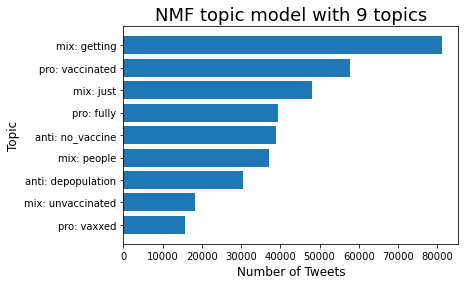

In [275]:
# plot of tweets per topic

plt.barh(x, y)
plt.title('NMF topic model with 9 topics', fontsize=18)
plt.xlabel('Number of Tweets', fontsize=12)
plt.ylabel('Topic', fontsize=12)
#plt.xticks(['10K', '20K', '30K', '40K', '50K', '60K', '70K', '80K'])
plt.yticks(x, topic_list);

### Plotting Tweets over time per topic

In [166]:
# prepare to plot Tweets over time (for each topic)

def prep_topic_plots(topic):
    topic_df = doc_topic_df[doc_topic_df['topic'] == topic]
    date_df = topic_df.groupby('date')[ 'text'].count() \
        .reset_index()
    
    # drop April 21st (last day in this dataset) because may just be a partial day
    if len(date_df) == 172:
        date_df.drop([171], axis=0, inplace=True)
    else:
        pass
    
    # compute a 7 day rolling average (first 6 days will be null)
    date_df['7day_rolling_avg'] = date_df['text'].rolling(7).mean()
    date_df.head(10)

    x = date_df['date']
    y = date_df['7day_rolling_avg']
    topic = topic
    return x,y, topic

In [ ]:
topic_list = ['pro: vaxxed', 'mix: unvaccinated', 'anti: depopulation',
             'mix: people', 'anti: no_vaccine', 'pro: fully', 'mix: just',
             'pro: vaccinated', 'mix: getting']

In [254]:
x1, y1, topic1 = prep_topic_plots('1_vaxxed')
x2, y2, topic2 = prep_topic_plots('2_unvaccinated')
x3, y3, topic3 = prep_topic_plots('3_depopulation')
x4, y4, topic4 = prep_topic_plots('4_people')
x5, y5, topic5 = prep_topic_plots('5_no_vaccine')
x6, y6, topic6 = prep_topic_plots('6_fully')
x7, y7, topic7 = prep_topic_plots('7_just')
x8, y8, topic8 = prep_topic_plots('8_vaccinated')
x9, y9, topic9 = prep_topic_plots('9_getting')

In [261]:
#xtick_labels = ['Nov 2020', 'Dec 2020', 'Jan 2021', 'Feb 2021', 'March 2021', 'April 2021']

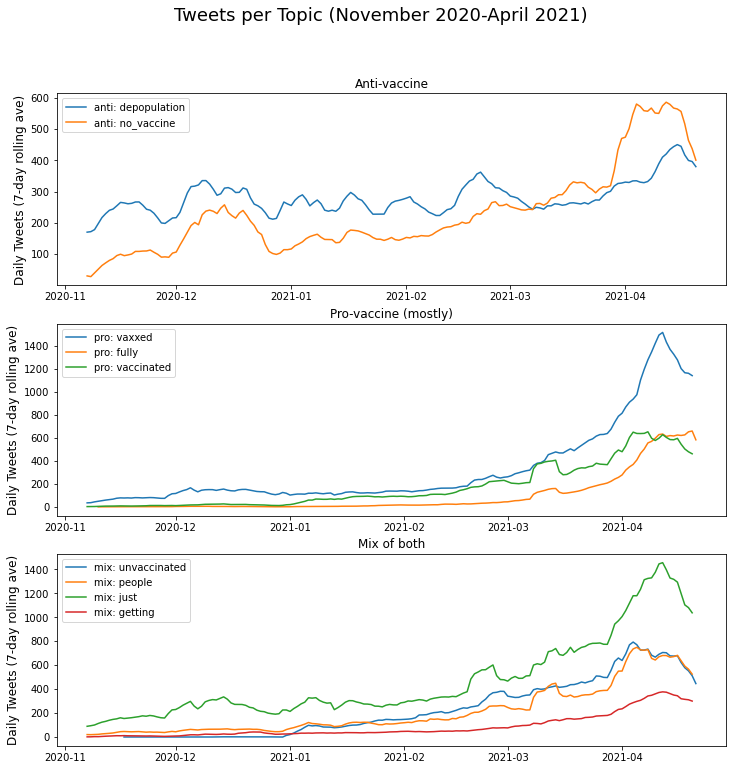

In [266]:
# for each topic, graph date vs count - 7 day rolling average

plt.figure(figsize=[12,12])
plt.suptitle('Tweets per Topic (November 2020-April 2021)', fontsize=18)

plt.subplot(3,1,1) # num rows, num columns, current num
plt.plot(x3, y3, label=topic_list[2])
plt.plot(x5, y5, label=topic_list[4])
plt.title('Anti-vaccine')
plt.legend()
plt.ylabel('Daily Tweets (7-day rolling ave)', fontsize=12)

plt.subplot(3,1,2)
plt.plot(x1, y1, label=topic_list[0])
plt.plot(x6, y6, label=topic_list[5])
plt.plot(x8, y8, label=topic_list[7])
plt.title('Pro-vaccine (mostly)')
plt.legend()
plt.ylabel('Daily Tweets (7-day rolling ave)', fontsize=12)

plt.subplot(3,1,3)
plt.plot(x2, y2, label=topic_list[1])
plt.plot(x4, y4, label=topic_list[3])
plt.plot(x7, y7, label=topic_list[6])
plt.plot(x9, y9, label=topic_list[8])
plt.title('Mix of both')
plt.legend()
plt.ylabel('Daily Tweets (7-day rolling ave)', fontsize=12);